In [ ]:
from PIL import Image
import torch
import torchvision.transforms as transforms
from torchvision.models import resnet50
import faiss
import cv2
from torch import nn

# --- 1. Load Pre-trained Models ---

# Load a pre-trained ResNet-50 for image embeddings
resnet_model = resnet50(pretrained=True)
resnet_model.eval()

# Load a pre-trained object detection model (e.g., YOLOv5)
# Replace with your actual YOLOv5 model loading code
yolo_model = torch.hub.load('ultralytics/yolov5', 'yolov5s') 

# --- 2. Define Image Transformations ---

transform = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

# --- 3. Feature Extraction Function ---

def extract_features(image_path):
    """Extracts image features using ResNet-50."""
    img = Image.open(image_path).convert('RGB')
    img_tensor = transform(img).unsqueeze(0)
    with torch.no_grad():
        features = resnet_model(img_tensor)
    return features.squeeze().numpy()

# --- 4. Object Detection Function ---

def detect_objects(image_path):
    """Detects objects in the image using YOLOv5."""
    results = yolo_model(image_path)
    print(results)
    return results.pandas().xyxy[0].to_dict('records') 

# --- 5. Extract Region Features ---

def extract_region_features(image_path, bbox):
    """Extracts features from the specified region of the image."""
    try:
        img = cv2.imread(image_path)
        x1, y1, x2, y2 = map(int, bbox)
        cropped_img = img[y1:y2, x1:x2] 
        # Resize and preprocess the cropped region for feature extraction
        cropped_img = cv2.resize(cropped_img, (224, 224)) 
        cropped_img = cv2.cvtColor(cropped_img, cv2.COLOR_BGR2RGB)
        cropped_img = Image.fromarray(cropped_img)
        cropped_img_tensor = transform(cropped_img).unsqueeze(0)
        with torch.no_grad():
            features = resnet_model(cropped_img_tensor)
        return features.squeeze().numpy()
    except Exception as e:
        print(f"Error extracting region features: {e}")
        return None

# --- 6. Hybrid Search Function ---

def hybrid_search(query_image_path, image_paths, k=5):
    """Performs hybrid search using object detection and multimodal embeddings."""

    query_features = extract_features(query_image_path)
    all_features = []

    for image_path in image_paths:
        detections = detect_objects(image_path)
        
        for detection in detections:
            if detection['confidence'] > 0.8:  # Filter detections based on confidence
                try:
                    region_features = extract_region_features(image_path, detection[['xmin', 'ymin', 'xmax', 'ymax']]) 
                    if region_features is not None:
                        all_features.append(region_features)
                except Exception as e:
                    print(f"Error processing image: {e}") 

    all_features = np.array(all_features)
    index = faiss.IndexFlatL2(all_features.shape[1])
    index.add(all_features)
    distances, indices = index.search(query_features.reshape(1, -1), k=k)

    results = []
    for i in indices[0]:
        # You can add information about the detected region here if needed
        results.append({'image_path': image_paths[i]}) 

    return results

# --- Example Usage ---

query_image_path = "data/322879a99be84deedc5d77b59a1e3b85cf13b876111.jpeg"
image_paths = ["image1.jpg", "image2.jpg", ...] 
results = hybrid_search(query_image_path, image_paths)

for result in results:
    print(f"Image Path: {result['image_path']}")

In [ ]:
def detect_objects(image_path):
    """Detects objects in the image using YOLOv5."""
    results = yolo_model(image_path)
    print(results)
    return results.pandas().xyxy[0].to_dict('records') 

In [ ]:
detect_objects("data/322879a99be84deedc5d77b59a1e3b85cf13b876111.jpeg")

In [ ]:
!pip install faiss-cpu

In [ ]:
!pip install torch torchvision torchaudio # Install PyTorch if not already installed


In [ ]:

# 1. Load a pre-trained EfficientDet model from torchvision 
import torch
from torchvision.models import efficientnet_b0 as det 
model = det(pretrained=True) 
model.eval() 

# 2. Define image transformations
import torchvision.transforms as transforms
transform = transforms.Compose([
    transforms.ToTensor(), 
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

# 3. Load and preprocess the image
from PIL import Image
import numpy as np
import cv2

def load_and_preprocess(image_path):
  img = Image.open(image_path).convert('RGB') 
  img_tensor = transform(img).unsqueeze(0) 
  return img_tensor

# 4. Perform object detection
def detect_objects(image_path):
  img_tensor = load_and_preprocess(image_path) 
  with torch.no_grad():
    outputs = model(img_tensor) 

  return outputs[0] # Get the detection results

# 5. Visualize detections (optional)
import matplotlib.pyplot as plt

def visualize_detections(image_path, outputs):
  img = cv2.imread(image_path) 
  for box in outputs['boxes']:
    x1, y1, x2, y2 = box.tolist() 
    x1, y1, x2, y2 = int(x1), int(y1), int(x2), int(y2) 
    cv2.rectangle(img, (x1, y1), (x2, y2), (0, 255, 0), 2) 

  plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB)) 
  plt.show()

# Example usage
image_path = "data/6770fe9d6f63d6dad7e2947615912f86755c493c.jpeg" 
outputs = detect_objects(image_path)
visualize_detections(image_path, outputs) 

# Access detection results (e.g., bounding boxes, labels, scores)
for box, label, score in zip(outputs['boxes'], outputs['labels'], outputs['scores']):
  print(f"Class: {model.classes[label]}, Score: {score:.2f}, Box: {box.tolist()}")

Predicted Class: whistle (Class index: 902)


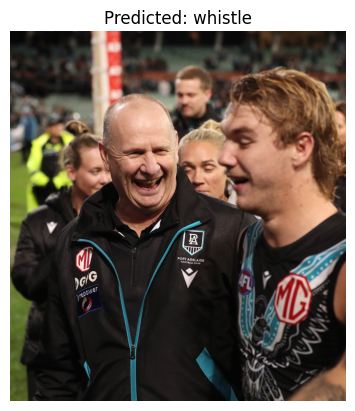

In [15]:
import torch
import torchvision.transforms as transforms
from torchvision import models
from PIL import Image
import requests
from io import BytesIO
import matplotlib.pyplot as plt

# Load the pre-trained EfficientNet-B0 model
model = models.efficientnet_b0(pretrained=True)
model.eval()  # Set the model to evaluation mode

# Define the image transformation pipeline
transform = transforms.Compose([
    transforms.Resize(256),  # Resize image to 256x256
    transforms.CenterCrop(224),  # Crop to 224x224 (required input size for EfficientNet)
    transforms.ToTensor(),  # Convert image to tensor
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),  # Normalize
])

# Load and preprocess the image

# If you want to load the image from a URL
# image_url = 'https://example.com/your_image.jpg'
# response = requests.get(image_url)
# img = Image.open(BytesIO(response.content))

# Load image using PIL
img = Image.open(image_path)

# Apply the transformations
input_tensor = transform(img)
input_batch = input_tensor.unsqueeze(0)  # Add batch dimension

# Check if GPU is available, otherwise use CPU
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.to(device)
input_batch = input_batch.to(device)

# Perform inference
with torch.no_grad():
    output = model(input_batch)


# The output contains the raw logits; apply softmax to get probabilities
probabilities = torch.nn.functional.softmax(output[0], dim=0)

# Load the labels for ImageNet (EfficientNet-B0 is trained on ImageNet)
LABELS_URL = "https://storage.googleapis.com/download.tensorflow.org/data/imagenet_class_index.json"
labels_response = requests.get(LABELS_URL)
labels = labels_response.json()

# Get the predicted class
class_idx = torch.argmax(probabilities).item()
class_name = labels[str(class_idx)][1]  # Get the human-readable label

# Print the predicted class
print(f"Predicted Class: {class_name} (Class index: {class_idx})")

# Show the image with predicted label
plt.imshow(img)
plt.title(f"Predicted: {class_name}")
plt.axis('off')
plt.show()


In [26]:
image_path='data/322879a99be84deedc5d77b59a1e3b85cf13b876111.jpeg'

In [29]:
import torch
import matplotlib.pyplot as plt
import cv2
from PIL import Image
import numpy as np

# Load the pre-trained YOLOv5 model (smallest version: yolov5s)
model = torch.hub.load('ultralytics/yolov5', 'yolov5s', pretrained=True)

# Load image using OpenCV or PIL (depending on your source)
img = Image.open(image_path)  # PIL Image
img = np.array(img)  # Convert PIL image to numpy array (required for OpenCV)

# Perform inference using the model (detect objects in the image)
results = model(img)  # This gives the results, which include bounding boxes

# Results: You can access details like the bounding boxes, labels, and confidences
boxes = results.xyxy[0].cpu().numpy()  # (x1, y1, x2, y2, confidence, class)
labels = results.names  # Class labels
confidence_threshold = 0.3 # You can filter out detections with lower confidence


# Draw the bounding boxes on the image
idx=0
print(boxes)
for box in boxes:
    print(box)
    if box[4] >= confidence_threshold:  # Check if the detection confidence is above threshold
        x1, y1, x2, y2, conf, cls = box
        label = labels[int(cls)]  # Get the class label for the box
        
        # Crop the region inside the bounding box
        cropped_image = img[int(y1):int(y2), int(x1):int(x2)]
        plt.imshow(img)
        plt.title(f"Predicted: {class_name}")
        plt.axis('off')
        plt.show()

        # Save the cropped image to the output directory with a unique filename
        cropped_image_filename = f"{label}_{conf:.2f}_{idx}.jpg"
        cropped_image_path = 'data/'+ cropped_image_filename
        cv2.imwrite(cropped_image_path, cropped_image)
        idx=idx+1
        
        
#         # Draw the rectangle on the image using OpenCV
#         img = cv2.rectangle(img, (int(x1), int(y1)), (int(x2), int(y2)), (255, 0, 0), 2)
#         img = cv2.putText(img, f"{label} {conf:.2f}", (int(x1), int(y1) - 10), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (255, 0, 0), 2)
        
# # Convert back to PIL for displaying with Matplotlib
# img_pil = Image.fromarray(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))

# # Display the image with bounding boxes
# plt.figure(figsize=(10, 10))
# plt.imshow(img_pil)
# plt.axis('off')  # Hide axes
# plt.show()


Using cache found in /home/jupyter/.cache/torch/hub/ultralytics_yolov5_master
YOLOv5 🚀 2024-12-14 Python-3.10.14 torch-2.5.1+cu124 CPU

Fusing layers... 
YOLOv5s summary: 213 layers, 7225885 parameters, 0 gradients, 16.4 GFLOPs
Adding AutoShape... 
/home/jupyter/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


[]


In [20]:
boxes

array([[     1293.5,      274.86,      1720.8,      885.49,     0.82792,           0],
       [       1354,      747.81,      1843.8,      1437.4,     0.77358,           0],
       [     55.804,      491.42,      2000.3,      2983.4,     0.71337,           0],
       [     124.28,      648.36,      484.31,      1460.9,     0.59162,           0],
       [     1595.3,      281.96,        2705,      2985.7,     0.51843,           0],
       [     4.2778,      786.03,       786.7,      2972.1,      0.4101,           0],
       [     418.79,      719.75,      659.67,      917.89,     0.36384,           0]], dtype=float32)